In [1]:
import re
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.corpus import gutenberg
from wordcloud import WordCloud

try:
    import networkx as nx
    HAS_NX = True
except Exception:
    HAS_NX = False

In [2]:
# First run only: download corpora
nltk.download("punkt", quiet=True)
nltk.download("stopwords", quiet=True)
nltk.download("gutenberg", quiet=True)

True

In [3]:
# 1) Load corpus (Jane Austen - "Emma")
# -----------------------------------------------------------
text = gutenberg.raw("austen-emma.txt")
print("Corpus length (characters):", len(text))
print(text[:500])  # preview

Corpus length (characters): 887071
[Emma by Jane Austen 1816]

VOLUME I

CHAPTER I


Emma Woodhouse, handsome, clever, and rich, with a comfortable home
and happy disposition, seemed to unite some of the best blessings
of existence; and had lived nearly twenty-one years in the world
with very little to distress or vex her.

She was the youngest of the two daughters of a most affectionate,
indulgent father; and had, in consequence of her sister's marriage,
been mistress of his house from a very early period.  Her mother
had died t


In [4]:
 # 2) Clean & tokenize
# -----------------------------------------------------------
sw = set(stopwords.words("english"))
custom_sw = {"said", "mr", "mrs"}   # extend if you want
sw |= custom_sw

token_pattern = re.compile(r"[A-Za-zÀ-ÖØ-öø-ÿ]+(?:'[A-Za-zÀ-ÖØ-öø-ÿ]+)?")

def tokenize_clean(s: str):
    tokens = token_pattern.findall(s.lower())
    tokens = [t for t in tokens if t not in sw and len(t) > 2]
    return tokens

tokens = tokenize_clean(text)
print("Tokens:", len(tokens))
print(tokens[:20])

Tokens: 70402
['emma', 'jane', 'austen', 'volume', 'chapter', 'emma', 'woodhouse', 'handsome', 'clever', 'rich', 'comfortable', 'home', 'happy', 'disposition', 'seemed', 'unite', 'best', 'blessings', 'existence', 'lived']


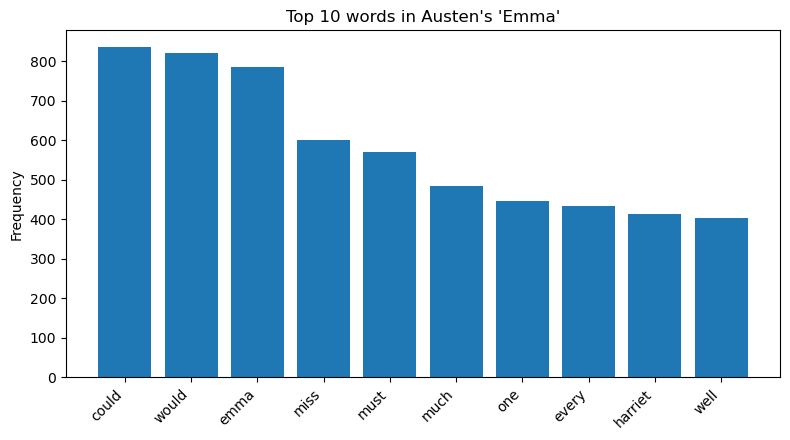

In [5]:
# 3) Word frequencies
# -----------------------------------------------------------
freq = Counter(tokens)
top_n = 10
words, counts = zip(*freq.most_common(top_n))

plt.figure(figsize=(8, 4.5))
plt.bar(words, counts)
plt.xticks(rotation=45, ha="right")
plt.title(f"Top {top_n} words in Austen's 'Emma'")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

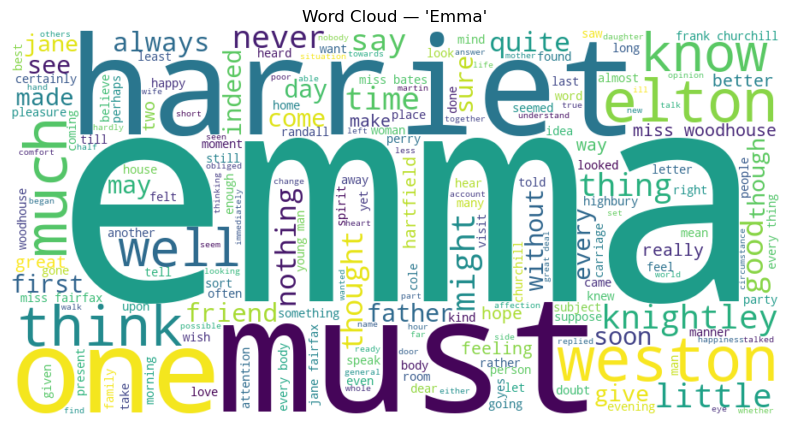

In [6]:
# 4) Word cloud
# -----------------------------------------------------------
clean_text = " ".join(tokens)

wc = WordCloud(width=900, height=450, background_color="white").generate(clean_text)

plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud — 'Emma'")
plt.show()

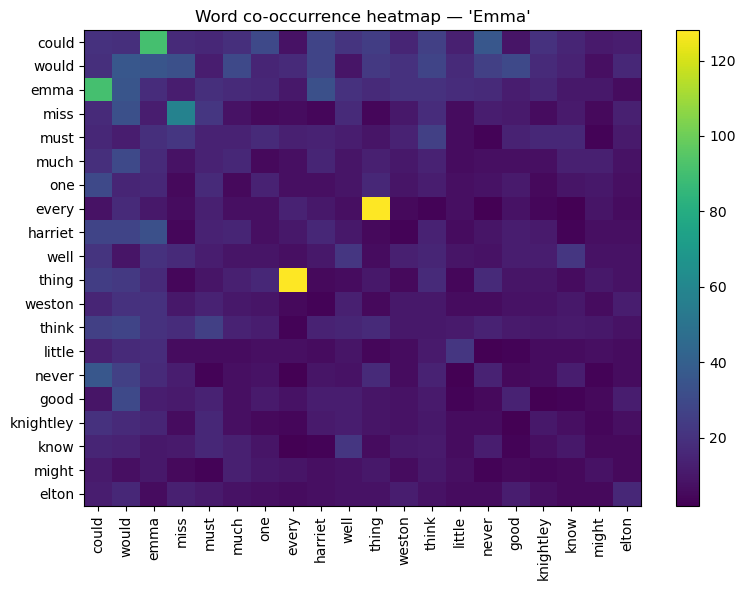

In [7]:
# 5) Co-occurrence (heatmap)
# -----------------------------------------------------------
window = 2
top_k = 20
vocab_top = [w for w, _ in freq.most_common(top_k)]
idx = {w: i for i, w in enumerate(vocab_top)}
cooc = np.zeros((top_k, top_k), dtype=int)

for i, w in enumerate(tokens):
    if w not in idx:
        continue
    left = max(0, i - window)
    right = min(len(tokens), i + window + 1)
    for j in range(left, right):
        if i == j:
            continue
        w2 = tokens[j]
        if w2 in idx:
            cooc[idx[w], idx[w2]] += 1

cooc_df = pd.DataFrame(cooc, index=vocab_top, columns=vocab_top)

plt.figure(figsize=(8, 6))
plt.imshow(cooc_df.values, aspect="auto")
plt.colorbar()
plt.xticks(range(len(vocab_top)), vocab_top, rotation=90)
plt.yticks(range(len(vocab_top)), vocab_top)
plt.title("Word co-occurrence heatmap — 'Emma'")
plt.tight_layout()
plt.show()

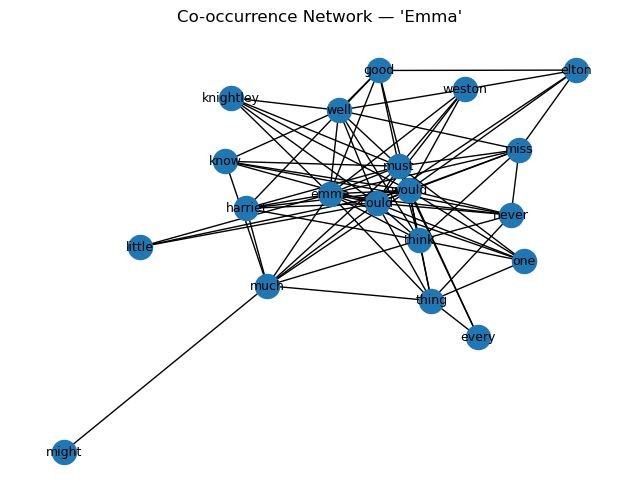

In [8]:
# 6) Optional network graph
# -----------------------------------------------------------
if HAS_NX:
    threshold = max(2, int(cooc_df.values.mean()))
    G = nx.Graph()
    for w in vocab_top:
        G.add_node(w)

    for i, w1 in enumerate(vocab_top):
        for j, w2 in enumerate(vocab_top):
            if j <= i:
                continue
            weight = cooc_df.iloc[i, j]
            if weight >= threshold:
                G.add_edge(w1, w2, weight=int(weight))

    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G, seed=42)
    nx.draw_networkx_nodes(G, pos)
    nx.draw_networkx_edges(G, pos)
    nx.draw_networkx_labels(G, pos, font_size=9)
    plt.title("Co-occurrence Network — 'Emma'")
    plt.axis("off")
    plt.show()
else:
    print("Install networkx for network visualization")